# Algorithm 1: Performative Risk Control

### Set up

In [3]:
# Experimental setup arguments

class args:
    alpha = 0.2         # risk control level
    tightness = 0.12    # tightness parameter, may throw error if too low
    delta = 0.1         # failure probability or confidence parameter

    tau = 1.            # safety parameter
    L = 5              # Lipschitz constant

    gamma = 0.2        # sensitivity constant, must be <= tau / L from the theory

    N = 3000            # number of samples in cohort

    lambda_max = 1.0    # maximum value for lambda

    ell_max = 1.0

    # To calculate after the first round
    # delta_lambda      # max difference in lambda between consecutive rounds to guarantee tightness
    # T                 # number of rounds needed for theoretical guarantee
    # sigma_sq          # upper bound on variance on any distributional parameter lambda
    # M             # upper bound on the PDF of the initial data distribution

In [5]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [6]:
import os
os.chdir(r'C:\Users\chenbt\Downloads\rcpp-main\rcpp-main\GiveMeSomeCredit')

In [7]:
from data_prep import load_data
np.random.seed(42)

#path_to_csv_file = './data/cs-training.csv'
path_to_csv_file = './cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

d = X_all.shape[1] - 1
print('d=',d)

# Total number of samples
total_samples = X_all.shape[0]

# First: split off 3000 for training
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_all, Y_all, train_size=3000, random_state=42
)


# Clean up
del X_all, Y_all

d= 10


In [8]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


[[ 0.07021367 -0.37790385  1.38865649 -0.31126216 -0.69039597  0.02952907
   1.01885607  0.11360131 -0.89831213  0.16047303 -0.43313032]]


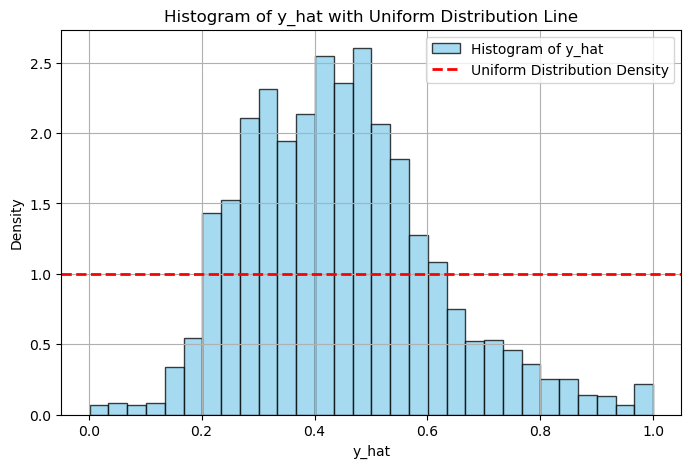

In [13]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)
Y_hat = model.predict_proba(X_train)[:,1]


# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Compute M: Upper bound of the PDF
M= counts.max()

In [15]:
def hoeffding_bound(T, epsilon, n):

    delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)
    return args.ell_max * np.sqrt((1 / (2 * n)) * np.log(2 / delta_prime))

In [17]:
def satisfies_risk_control(epsilon, n):
    """
    Checks if the inequality holds for a given epsilon.
    """
    T = int(1 + (args.lambda_max / epsilon)) 
    disc_error = (args.tau + args.L) * epsilon
    gen_error = 2 * hoeffding_bound(T, epsilon, n)
    return disc_error + gen_error <= args.tightness

def find_largest_feasible_epsilon(n, tol=1e-5):
    eps_low, eps_high = 1e-6, 1.0
    best_eps = 0.0

    while eps_high - eps_low > tol:
        mid = (eps_low + eps_high) / 2
        if satisfies_risk_control(mid, n):
            best_eps = mid
            eps_low = mid
        else:
            eps_high = mid

    return best_eps

epsilon = find_largest_feasible_epsilon(args.N)
print(f"Largest feasible ε: {epsilon:.6f}")

def construct_epsilon_net(epsilon, lambda_max):
    if epsilon <= 0:
        raise ValueError("epsilon must be positive.")
    
    num_points = int(1 / epsilon) + 1
    return [k * epsilon * lambda_max for k in range(num_points)]

epsilon_net = construct_epsilon_net(epsilon, args.lambda_max)
#print("Epsilon-net:", epsilon_net)
T = int(1 + (args.lambda_max / epsilon)) 

Largest feasible ε: 0.005136


# Experiment

In [20]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    assert len(Y_proba.shape) == 1
    return np.clip(1. - args.L * (Y_proba - (1 - thresh)), 0, 1)

    # Optimization 2: compute less
    #assert len(Y_proba.shape) == 1
    #return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    assert len(Y.shape) == 1
    assert len(Y_proba.shape) == 1
    return ((Y == 1) * piecewise_fn(Y_proba, thresh))

def modify(Y_proba, threshold):
    shift = args.gamma / M
    condition = (1 - threshold) < (Y_proba - shift)

    Y_proba_new = Y_proba.copy()
    Y_proba_new[~condition] -= shift
    Y_proba_new = np.clip(Y_proba_new, 0, 1)

    return Y_proba_new

In [22]:
from tqdm import tqdm

def run_trajectory(Y, Y_proba, epsilon_net, verbose=False):
    
    # Precompute Hoeffding generalization bound
    bound = hoeffding_bound(T, epsilon, args.N)
    print(f"Using Hoeffding bound: {bound:.4f}")

    # Initialization
    thresh = args.lambda_max
    losses, errs, threshes = [0.], [0.], [thresh]

    iters = tqdm(range(1, T + 1)) if verbose else range(1, T + 1)

    for t in iters:
        # Step 1: Apply performative modification
        Y_proba_t = modify(Y_proba, thresh)

        # Step 2: Evaluate loss and type II error
        err_t = float(type_II_error(Y, Y_proba_t, thresh))
        loss_t = float(np.mean(piecewise_loss(Y, Y_proba_t, thresh)))
        errs.append(err_t)
        losses.append(loss_t)

        # Step 3: Filter ε-net to candidates below current threshold
        valid_threshes = []
        for lam in epsilon_net:
            risk = np.mean(piecewise_loss(Y, Y_proba_t, lam)) \
                   + args.tau * (thresh - lam) \
                   + bound
            if risk <= args.alpha:
                valid_threshes.append(lam)

        # Step 4: If no valid thresholds, return
        if len(valid_threshes) == 0:
            valid_threshes.append(thresh)

        # Step 4: Greedy update to smallest valid lambda
        new_thresh = min(valid_threshes)
        #print(f"Iter {t}: Loss: {loss_t:.4f}, Type II error: {err_t:.4f}, "
        #      f"Threshold: {thresh:.4f}, New Threshold: {new_thresh:.4f}")

        thresh = new_thresh
        threshes.append(thresh)

    return losses, threshes, errs

### Run

In [25]:
X_cal, X_test, Y_cal, Y_test = train_test_split(
    X_temp, Y_temp, train_size=10000, random_state=42
)
Y_proba = model.predict_proba(X_cal)[:,1]
#losses, threshes, errs = run_trajectory(Y_cv, Y_proba)
losses, threshes, errs = run_trajectory(Y_cal, Y_proba, epsilon_net)

Using Hoeffding bound: 0.0446


Text(0, 0.1, 'Guaranteed convergence by T=195')

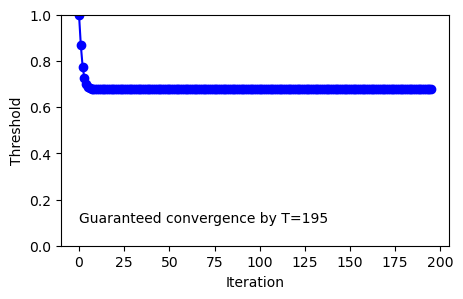

In [27]:
# Plot threshold trajectory
plt.figure(figsize=(5, 3))
plt.ylim(0, args.lambda_max)
plt.plot(threshes, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Threshold')
plt.text(0, 0.1, f"Guaranteed convergence by T={T}")

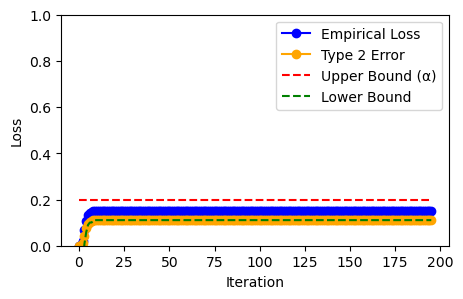

In [29]:
# Plot loss trajectory

upper_bound = [args.alpha for _ in range(len(losses))]
lower_bound = [-np.inf]
for i in range(1, len(losses)):
    delta_lambda = np.maximum(0., threshes[i-1] - threshes[i])
    slack = 2 * hoeffding_bound(T, epsilon, args.N) + 2 * args.tau * delta_lambda
    lower_bound.append(float(args.alpha - slack))

#print(losses)
#print(upper_bound)
#print(lower_bound)

plt.figure(figsize=(5, 3))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Empirical Loss')
plt.plot(errs, marker='o', linestyle='-', color='orange', label='Type 2 Error')
plt.plot(upper_bound, linestyle='--', color='r', label='Upper Bound (α)')
plt.plot(lower_bound, linestyle='--', color='g', label='Lower Bound')
plt.ylim(0, 1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on the test set

In [32]:
# Use the threshold for test set

final_thresh = threshes[-1]
Y_proba_test = model.predict_proba(X_test)[:,1]
Y_proba_test_mod = modify(Y_proba_test, final_thresh)
test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

In [34]:
print(f"Final threshold: {final_thresh:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Type II error: {test_error:.4f}")

Final threshold: 0.6779
Test loss: 0.1519
Test Type II error: 0.1127


### 1000 runs

In [37]:
# 1000 runs with different splits

num_runs = 1000
all_test_losses = []
all_test_errors = []
all_final_thresholds = []

for seed in tqdm(range(num_runs)):
    # Step 1: Split calibration/test
    X_cal, X_test, Y_cal, Y_test = train_test_split(
        X_temp, Y_temp, train_size=10000, random_state=seed
    )

    # Step 2: Predict probabilities
    Y_proba_cal = model.predict_proba(X_cal)[:, 1]
    Y_proba_test = model.predict_proba(X_test)[:, 1]

    # Step 3: Run PRC
    losses, threshes, errs = run_trajectory(Y_cal, Y_proba_cal, epsilon_net)
    final_thresh = threshes[-1]

    # Step 4: Evaluate on test set
    Y_proba_test_mod = modify(Y_proba_test, final_thresh)
    test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
    test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

    # Step 5: Store results
    all_test_losses.append(test_loss)
    all_test_errors.append(test_error)
    all_final_thresholds.append(final_thresh)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Using Hoeffding bound: 0.0446


  0%|                                                                                 | 1/1000 [00:01<33:00,  1.98s/it]

Using Hoeffding bound: 0.0446


  0%|▏                                                                                | 2/1000 [00:04<35:49,  2.15s/it]

Using Hoeffding bound: 0.0446


  0%|▏                                                                                | 3/1000 [00:06<35:00,  2.11s/it]

Using Hoeffding bound: 0.0446


  0%|▎                                                                                | 4/1000 [00:08<34:17,  2.07s/it]

Using Hoeffding bound: 0.0446


  0%|▍                                                                                | 5/1000 [00:10<34:03,  2.05s/it]

Using Hoeffding bound: 0.0446


  1%|▍                                                                                | 6/1000 [00:12<34:04,  2.06s/it]

Using Hoeffding bound: 0.0446


  1%|▌                                                                                | 7/1000 [00:14<34:57,  2.11s/it]

Using Hoeffding bound: 0.0446


  1%|▋                                                                                | 8/1000 [00:16<34:21,  2.08s/it]

Using Hoeffding bound: 0.0446


  1%|▋                                                                                | 9/1000 [00:18<34:15,  2.07s/it]

Using Hoeffding bound: 0.0446


  1%|▊                                                                               | 10/1000 [00:20<34:43,  2.10s/it]

Using Hoeffding bound: 0.0446


  1%|▉                                                                               | 11/1000 [00:22<34:25,  2.09s/it]

Using Hoeffding bound: 0.0446


  1%|▉                                                                               | 12/1000 [00:25<34:56,  2.12s/it]

Using Hoeffding bound: 0.0446


  1%|█                                                                               | 13/1000 [00:27<34:34,  2.10s/it]

Using Hoeffding bound: 0.0446


  1%|█                                                                               | 14/1000 [00:29<35:05,  2.14s/it]

Using Hoeffding bound: 0.0446


  2%|█▏                                                                              | 15/1000 [00:31<35:13,  2.15s/it]

Using Hoeffding bound: 0.0446


  2%|█▎                                                                              | 16/1000 [00:33<35:21,  2.16s/it]

Using Hoeffding bound: 0.0446


  2%|█▎                                                                              | 17/1000 [00:36<36:37,  2.24s/it]

Using Hoeffding bound: 0.0446


  2%|█▍                                                                              | 18/1000 [00:38<36:25,  2.23s/it]

Using Hoeffding bound: 0.0446


  2%|█▌                                                                              | 19/1000 [00:40<36:30,  2.23s/it]

Using Hoeffding bound: 0.0446


  2%|█▌                                                                              | 20/1000 [00:42<37:01,  2.27s/it]

Using Hoeffding bound: 0.0446


  2%|█▋                                                                              | 21/1000 [00:45<36:53,  2.26s/it]

Using Hoeffding bound: 0.0446


  2%|█▊                                                                              | 22/1000 [00:47<37:16,  2.29s/it]

Using Hoeffding bound: 0.0446


  2%|█▊                                                                              | 23/1000 [00:49<36:38,  2.25s/it]

Using Hoeffding bound: 0.0446


  2%|█▉                                                                              | 24/1000 [00:52<37:38,  2.31s/it]

Using Hoeffding bound: 0.0446


  2%|██                                                                              | 25/1000 [00:54<36:42,  2.26s/it]

Using Hoeffding bound: 0.0446


  3%|██                                                                              | 26/1000 [00:56<35:15,  2.17s/it]

Using Hoeffding bound: 0.0446


  3%|██▏                                                                             | 27/1000 [00:58<35:07,  2.17s/it]

Using Hoeffding bound: 0.0446


  3%|██▏                                                                             | 28/1000 [01:00<34:16,  2.12s/it]

Using Hoeffding bound: 0.0446


  3%|██▎                                                                             | 29/1000 [01:02<33:49,  2.09s/it]

Using Hoeffding bound: 0.0446


  3%|██▍                                                                             | 30/1000 [01:04<34:23,  2.13s/it]

Using Hoeffding bound: 0.0446


  3%|██▍                                                                             | 31/1000 [01:06<34:56,  2.16s/it]

Using Hoeffding bound: 0.0446


  3%|██▌                                                                             | 32/1000 [01:09<34:41,  2.15s/it]

Using Hoeffding bound: 0.0446


  3%|██▋                                                                             | 33/1000 [01:11<34:15,  2.13s/it]

Using Hoeffding bound: 0.0446


  3%|██▋                                                                             | 34/1000 [01:13<34:55,  2.17s/it]

Using Hoeffding bound: 0.0446


  4%|██▊                                                                             | 35/1000 [01:15<34:36,  2.15s/it]

Using Hoeffding bound: 0.0446


  4%|██▉                                                                             | 36/1000 [01:17<34:04,  2.12s/it]

Using Hoeffding bound: 0.0446


  4%|██▉                                                                             | 37/1000 [01:19<34:30,  2.15s/it]

Using Hoeffding bound: 0.0446


  4%|███                                                                             | 38/1000 [01:21<33:41,  2.10s/it]

Using Hoeffding bound: 0.0446


  4%|███                                                                             | 39/1000 [01:23<33:04,  2.07s/it]

Using Hoeffding bound: 0.0446


  4%|███▏                                                                            | 40/1000 [01:25<33:11,  2.07s/it]

Using Hoeffding bound: 0.0446


  4%|███▎                                                                            | 41/1000 [01:28<33:39,  2.11s/it]

Using Hoeffding bound: 0.0446


  4%|███▎                                                                            | 42/1000 [01:30<35:06,  2.20s/it]

Using Hoeffding bound: 0.0446


  4%|███▍                                                                            | 43/1000 [01:32<36:28,  2.29s/it]

Using Hoeffding bound: 0.0446


  4%|███▌                                                                            | 44/1000 [01:35<37:17,  2.34s/it]

Using Hoeffding bound: 0.0446


  4%|███▌                                                                            | 45/1000 [01:38<38:54,  2.44s/it]

Using Hoeffding bound: 0.0446


  5%|███▋                                                                            | 46/1000 [01:41<41:15,  2.59s/it]

Using Hoeffding bound: 0.0446


  5%|███▊                                                                            | 47/1000 [01:44<43:42,  2.75s/it]

Using Hoeffding bound: 0.0446


  5%|███▊                                                                            | 48/1000 [01:46<43:40,  2.75s/it]

Using Hoeffding bound: 0.0446


  5%|███▉                                                                            | 49/1000 [01:49<43:35,  2.75s/it]

Using Hoeffding bound: 0.0446


  5%|████                                                                            | 50/1000 [01:52<42:22,  2.68s/it]

Using Hoeffding bound: 0.0446


  5%|████                                                                            | 51/1000 [01:54<39:46,  2.51s/it]

Using Hoeffding bound: 0.0446


  5%|████▏                                                                           | 52/1000 [01:56<38:04,  2.41s/it]

Using Hoeffding bound: 0.0446


  5%|████▏                                                                           | 53/1000 [01:58<35:59,  2.28s/it]

Using Hoeffding bound: 0.0446


  5%|████▎                                                                           | 54/1000 [02:00<34:28,  2.19s/it]

Using Hoeffding bound: 0.0446


  6%|████▍                                                                           | 55/1000 [02:02<33:21,  2.12s/it]

Using Hoeffding bound: 0.0446


  6%|████▍                                                                           | 56/1000 [02:04<32:23,  2.06s/it]

Using Hoeffding bound: 0.0446


  6%|████▌                                                                           | 57/1000 [02:06<32:05,  2.04s/it]

Using Hoeffding bound: 0.0446


  6%|████▋                                                                           | 58/1000 [02:08<31:33,  2.01s/it]

Using Hoeffding bound: 0.0446


  6%|████▋                                                                           | 59/1000 [02:10<31:17,  1.99s/it]

Using Hoeffding bound: 0.0446


  6%|████▊                                                                           | 60/1000 [02:12<31:34,  2.02s/it]

Using Hoeffding bound: 0.0446


  6%|████▉                                                                           | 61/1000 [02:14<31:21,  2.00s/it]

Using Hoeffding bound: 0.0446


  6%|████▉                                                                           | 62/1000 [02:16<31:06,  1.99s/it]

Using Hoeffding bound: 0.0446


  6%|█████                                                                           | 63/1000 [02:18<30:53,  1.98s/it]

Using Hoeffding bound: 0.0446


  6%|█████                                                                           | 64/1000 [02:20<31:02,  1.99s/it]

Using Hoeffding bound: 0.0446


  6%|█████▏                                                                          | 65/1000 [02:22<31:06,  2.00s/it]

Using Hoeffding bound: 0.0446


  7%|█████▎                                                                          | 66/1000 [02:24<31:34,  2.03s/it]

Using Hoeffding bound: 0.0446


  7%|█████▎                                                                          | 67/1000 [02:26<31:23,  2.02s/it]

Using Hoeffding bound: 0.0446


  7%|█████▍                                                                          | 68/1000 [02:28<31:17,  2.01s/it]

Using Hoeffding bound: 0.0446


  7%|█████▌                                                                          | 69/1000 [02:30<30:55,  1.99s/it]

Using Hoeffding bound: 0.0446


  7%|█████▌                                                                          | 70/1000 [02:32<30:48,  1.99s/it]

Using Hoeffding bound: 0.0446


  7%|█████▋                                                                          | 71/1000 [02:34<30:35,  1.98s/it]

Using Hoeffding bound: 0.0446


  7%|█████▊                                                                          | 72/1000 [02:36<30:42,  1.99s/it]

Using Hoeffding bound: 0.0446


  7%|█████▊                                                                          | 73/1000 [02:38<30:38,  1.98s/it]

Using Hoeffding bound: 0.0446


  7%|█████▉                                                                          | 74/1000 [02:40<30:36,  1.98s/it]

Using Hoeffding bound: 0.0446


  8%|██████                                                                          | 75/1000 [02:41<30:16,  1.96s/it]

Using Hoeffding bound: 0.0446


  8%|██████                                                                          | 76/1000 [02:43<30:24,  1.97s/it]

Using Hoeffding bound: 0.0446


  8%|██████▏                                                                         | 77/1000 [02:45<30:25,  1.98s/it]

Using Hoeffding bound: 0.0446


  8%|██████▏                                                                         | 78/1000 [02:48<31:08,  2.03s/it]

Using Hoeffding bound: 0.0446


  8%|██████▎                                                                         | 79/1000 [02:50<31:06,  2.03s/it]

Using Hoeffding bound: 0.0446


  8%|██████▍                                                                         | 80/1000 [02:52<31:02,  2.02s/it]

Using Hoeffding bound: 0.0446


  8%|██████▍                                                                         | 81/1000 [02:54<30:45,  2.01s/it]

Using Hoeffding bound: 0.0446


  8%|██████▌                                                                         | 82/1000 [02:56<30:36,  2.00s/it]

Using Hoeffding bound: 0.0446


  8%|██████▋                                                                         | 83/1000 [02:58<30:15,  1.98s/it]

Using Hoeffding bound: 0.0446


  8%|██████▋                                                                         | 84/1000 [03:00<31:57,  2.09s/it]

Using Hoeffding bound: 0.0446


  8%|██████▊                                                                         | 85/1000 [03:02<32:01,  2.10s/it]

Using Hoeffding bound: 0.0446


  9%|██████▉                                                                         | 86/1000 [03:04<31:20,  2.06s/it]

Using Hoeffding bound: 0.0446


  9%|██████▉                                                                         | 87/1000 [03:06<30:50,  2.03s/it]

Using Hoeffding bound: 0.0446


  9%|███████                                                                         | 88/1000 [03:08<30:37,  2.01s/it]

Using Hoeffding bound: 0.0446


  9%|███████                                                                         | 89/1000 [03:10<30:27,  2.01s/it]

Using Hoeffding bound: 0.0446


  9%|███████▏                                                                        | 90/1000 [03:12<30:10,  1.99s/it]

Using Hoeffding bound: 0.0446


  9%|███████▎                                                                        | 91/1000 [03:14<29:52,  1.97s/it]

Using Hoeffding bound: 0.0446


  9%|███████▎                                                                        | 92/1000 [03:16<29:59,  1.98s/it]

Using Hoeffding bound: 0.0446


  9%|███████▍                                                                        | 93/1000 [03:18<29:53,  1.98s/it]

Using Hoeffding bound: 0.0446


  9%|███████▌                                                                        | 94/1000 [03:20<29:44,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|███████▌                                                                        | 95/1000 [03:22<29:35,  1.96s/it]

Using Hoeffding bound: 0.0446


 10%|███████▋                                                                        | 96/1000 [03:24<29:37,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|███████▊                                                                        | 97/1000 [03:26<29:37,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|███████▊                                                                        | 98/1000 [03:28<29:36,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|███████▉                                                                        | 99/1000 [03:30<29:31,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|███████▉                                                                       | 100/1000 [03:32<29:33,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|███████▉                                                                       | 101/1000 [03:33<29:31,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|████████                                                                       | 102/1000 [03:35<29:24,  1.96s/it]

Using Hoeffding bound: 0.0446


 10%|████████▏                                                                      | 103/1000 [03:37<29:16,  1.96s/it]

Using Hoeffding bound: 0.0446


 10%|████████▏                                                                      | 104/1000 [03:39<29:21,  1.97s/it]

Using Hoeffding bound: 0.0446


 10%|████████▎                                                                      | 105/1000 [03:41<29:20,  1.97s/it]

Using Hoeffding bound: 0.0446


 11%|████████▎                                                                      | 106/1000 [03:43<29:18,  1.97s/it]

Using Hoeffding bound: 0.0446


 11%|████████▍                                                                      | 107/1000 [03:45<29:22,  1.97s/it]

Using Hoeffding bound: 0.0446


 11%|████████▌                                                                      | 108/1000 [03:47<29:28,  1.98s/it]

Using Hoeffding bound: 0.0446


 11%|████████▌                                                                      | 109/1000 [03:49<29:21,  1.98s/it]

Using Hoeffding bound: 0.0446


 11%|████████▋                                                                      | 110/1000 [03:51<29:10,  1.97s/it]

Using Hoeffding bound: 0.0446


 11%|████████▊                                                                      | 111/1000 [03:53<29:00,  1.96s/it]

Using Hoeffding bound: 0.0446


 11%|████████▊                                                                      | 112/1000 [03:55<29:02,  1.96s/it]

Using Hoeffding bound: 0.0446


 11%|████████▉                                                                      | 113/1000 [03:57<29:10,  1.97s/it]

Using Hoeffding bound: 0.0446


 11%|█████████                                                                      | 114/1000 [03:59<29:01,  1.97s/it]

Using Hoeffding bound: 0.0446


 12%|█████████                                                                      | 115/1000 [04:01<28:48,  1.95s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▏                                                                     | 116/1000 [04:03<28:50,  1.96s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▏                                                                     | 117/1000 [04:05<28:56,  1.97s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▎                                                                     | 118/1000 [04:07<29:00,  1.97s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▍                                                                     | 119/1000 [04:09<28:48,  1.96s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▍                                                                     | 120/1000 [04:11<28:53,  1.97s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▌                                                                     | 121/1000 [04:13<29:03,  1.98s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▋                                                                     | 122/1000 [04:15<29:57,  2.05s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▋                                                                     | 123/1000 [04:17<30:28,  2.08s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▊                                                                     | 124/1000 [04:19<30:56,  2.12s/it]

Using Hoeffding bound: 0.0446


 12%|█████████▉                                                                     | 125/1000 [04:22<30:52,  2.12s/it]

Using Hoeffding bound: 0.0446


 13%|█████████▉                                                                     | 126/1000 [04:23<30:03,  2.06s/it]

Using Hoeffding bound: 0.0446


 13%|██████████                                                                     | 127/1000 [04:25<29:30,  2.03s/it]

Using Hoeffding bound: 0.0446


 13%|██████████                                                                     | 128/1000 [04:27<29:21,  2.02s/it]

Using Hoeffding bound: 0.0446


 13%|██████████▏                                                                    | 129/1000 [04:29<29:20,  2.02s/it]

Using Hoeffding bound: 0.0446


 13%|██████████▎                                                                    | 130/1000 [04:31<28:59,  2.00s/it]

Using Hoeffding bound: 0.0446


 13%|██████████▎                                                                    | 131/1000 [04:33<28:41,  1.98s/it]

Using Hoeffding bound: 0.0446


 13%|██████████▍                                                                    | 132/1000 [04:35<29:12,  2.02s/it]

Using Hoeffding bound: 0.0446


 13%|██████████▌                                                                    | 133/1000 [04:37<29:04,  2.01s/it]

Using Hoeffding bound: 0.0446


 13%|██████████▌                                                                    | 134/1000 [04:39<28:49,  2.00s/it]

Using Hoeffding bound: 0.0446


 14%|██████████▋                                                                    | 135/1000 [04:41<28:30,  1.98s/it]

Using Hoeffding bound: 0.0446


 14%|██████████▋                                                                    | 136/1000 [04:43<28:29,  1.98s/it]

Using Hoeffding bound: 0.0446


 14%|██████████▊                                                                    | 137/1000 [04:45<28:25,  1.98s/it]

Using Hoeffding bound: 0.0446


 14%|██████████▉                                                                    | 138/1000 [04:47<28:25,  1.98s/it]

Using Hoeffding bound: 0.0446


 14%|██████████▉                                                                    | 139/1000 [04:49<28:12,  1.97s/it]

Using Hoeffding bound: 0.0446


 14%|███████████                                                                    | 140/1000 [04:51<28:14,  1.97s/it]

Using Hoeffding bound: 0.0446


 14%|███████████▏                                                                   | 141/1000 [04:53<28:13,  1.97s/it]

Using Hoeffding bound: 0.0446


 14%|███████████▏                                                                   | 142/1000 [04:55<28:05,  1.96s/it]

Using Hoeffding bound: 0.0446


 14%|███████████▎                                                                   | 143/1000 [04:57<28:05,  1.97s/it]

Using Hoeffding bound: 0.0446


 14%|███████████▍                                                                   | 144/1000 [04:59<28:11,  1.98s/it]

Using Hoeffding bound: 0.0446


 14%|███████████▍                                                                   | 145/1000 [05:01<28:08,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|███████████▌                                                                   | 146/1000 [05:03<28:02,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|███████████▌                                                                   | 147/1000 [05:05<27:51,  1.96s/it]

Using Hoeffding bound: 0.0446


 15%|███████████▋                                                                   | 148/1000 [05:07<28:00,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|███████████▊                                                                   | 149/1000 [05:09<27:56,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|███████████▊                                                                   | 150/1000 [05:11<28:01,  1.98s/it]

Using Hoeffding bound: 0.0446


 15%|███████████▉                                                                   | 151/1000 [05:13<27:52,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|████████████                                                                   | 152/1000 [05:15<27:50,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|████████████                                                                   | 153/1000 [05:17<27:44,  1.97s/it]

Using Hoeffding bound: 0.0446


 15%|████████████▏                                                                  | 154/1000 [05:19<27:44,  1.97s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▏                                                                  | 155/1000 [05:21<27:33,  1.96s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▎                                                                  | 156/1000 [05:23<27:38,  1.97s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▍                                                                  | 157/1000 [05:25<27:35,  1.96s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▍                                                                  | 158/1000 [05:27<27:26,  1.96s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▌                                                                  | 159/1000 [05:29<27:48,  1.98s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▋                                                                  | 160/1000 [05:32<31:38,  2.26s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▋                                                                  | 161/1000 [05:34<31:51,  2.28s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▊                                                                  | 162/1000 [05:36<31:59,  2.29s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▉                                                                  | 163/1000 [05:38<30:35,  2.19s/it]

Using Hoeffding bound: 0.0446


 16%|████████████▉                                                                  | 164/1000 [05:40<29:41,  2.13s/it]

Using Hoeffding bound: 0.0446


 16%|█████████████                                                                  | 165/1000 [05:42<29:04,  2.09s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████                                                                  | 166/1000 [05:44<29:33,  2.13s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▏                                                                 | 167/1000 [05:46<28:45,  2.07s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▎                                                                 | 168/1000 [05:48<29:09,  2.10s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▎                                                                 | 169/1000 [05:50<28:38,  2.07s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▍                                                                 | 170/1000 [05:52<28:14,  2.04s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▌                                                                 | 171/1000 [05:54<27:55,  2.02s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▌                                                                 | 172/1000 [05:56<27:54,  2.02s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▋                                                                 | 173/1000 [05:58<27:47,  2.02s/it]

Using Hoeffding bound: 0.0446


 17%|█████████████▋                                                                 | 174/1000 [06:00<27:30,  2.00s/it]

Using Hoeffding bound: 0.0446


 18%|█████████████▊                                                                 | 175/1000 [06:02<27:12,  1.98s/it]

Using Hoeffding bound: 0.0446


 18%|█████████████▉                                                                 | 176/1000 [06:04<27:12,  1.98s/it]

Using Hoeffding bound: 0.0446


 18%|█████████████▉                                                                 | 177/1000 [06:06<27:08,  1.98s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████                                                                 | 178/1000 [06:08<27:08,  1.98s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▏                                                                | 179/1000 [06:10<26:52,  1.96s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▏                                                                | 180/1000 [06:12<26:56,  1.97s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▎                                                                | 181/1000 [06:14<26:56,  1.97s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▍                                                                | 182/1000 [06:16<28:11,  2.07s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▍                                                                | 183/1000 [06:18<27:46,  2.04s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▌                                                                | 184/1000 [06:20<27:35,  2.03s/it]

Using Hoeffding bound: 0.0446


 18%|██████████████▌                                                                | 185/1000 [06:22<27:41,  2.04s/it]

Using Hoeffding bound: 0.0446


 19%|██████████████▋                                                                | 186/1000 [06:24<27:24,  2.02s/it]

Using Hoeffding bound: 0.0446


 19%|██████████████▊                                                                | 187/1000 [06:26<27:04,  2.00s/it]

Using Hoeffding bound: 0.0446


 19%|██████████████▊                                                                | 188/1000 [06:28<27:05,  2.00s/it]

Using Hoeffding bound: 0.0446


 19%|██████████████▉                                                                | 189/1000 [06:30<26:58,  2.00s/it]

Using Hoeffding bound: 0.0446


 19%|███████████████                                                                | 190/1000 [06:32<26:46,  1.98s/it]

Using Hoeffding bound: 0.0446


 19%|███████████████                                                                | 191/1000 [06:34<26:32,  1.97s/it]

Using Hoeffding bound: 0.0446


 19%|███████████████▏                                                               | 192/1000 [06:36<26:35,  1.97s/it]

Using Hoeffding bound: 0.0446


 19%|███████████████▏                                                               | 193/1000 [06:38<26:42,  1.99s/it]

Using Hoeffding bound: 0.0446


 19%|███████████████▎                                                               | 194/1000 [06:40<26:30,  1.97s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▍                                                               | 195/1000 [06:42<26:20,  1.96s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▍                                                               | 196/1000 [06:44<26:30,  1.98s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▌                                                               | 197/1000 [06:46<26:28,  1.98s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▋                                                               | 198/1000 [06:48<26:29,  1.98s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▋                                                               | 199/1000 [06:50<26:15,  1.97s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▊                                                               | 200/1000 [06:52<26:18,  1.97s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▉                                                               | 201/1000 [06:54<26:22,  1.98s/it]

Using Hoeffding bound: 0.0446


 20%|███████████████▉                                                               | 202/1000 [06:56<26:14,  1.97s/it]

Using Hoeffding bound: 0.0446


 20%|████████████████                                                               | 203/1000 [06:58<26:02,  1.96s/it]

Using Hoeffding bound: 0.0446


 20%|████████████████                                                               | 204/1000 [07:00<26:11,  1.97s/it]

Using Hoeffding bound: 0.0446


 20%|████████████████▏                                                              | 205/1000 [07:02<26:07,  1.97s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▎                                                              | 206/1000 [07:04<26:00,  1.97s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▎                                                              | 207/1000 [07:06<25:51,  1.96s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▍                                                              | 208/1000 [07:08<25:58,  1.97s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▌                                                              | 209/1000 [07:10<26:03,  1.98s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▌                                                              | 210/1000 [07:12<25:55,  1.97s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▋                                                              | 211/1000 [07:14<25:47,  1.96s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▋                                                              | 212/1000 [07:16<25:49,  1.97s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▊                                                              | 213/1000 [07:18<25:48,  1.97s/it]

Using Hoeffding bound: 0.0446


 21%|████████████████▉                                                              | 214/1000 [07:20<26:02,  1.99s/it]

Using Hoeffding bound: 0.0446


 22%|████████████████▉                                                              | 215/1000 [07:22<25:51,  1.98s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████                                                              | 216/1000 [07:24<25:59,  1.99s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▏                                                             | 217/1000 [07:26<25:53,  1.98s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▏                                                             | 218/1000 [07:28<25:45,  1.98s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▎                                                             | 219/1000 [07:30<25:38,  1.97s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▍                                                             | 220/1000 [07:31<25:35,  1.97s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▍                                                             | 221/1000 [07:33<25:36,  1.97s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▌                                                             | 222/1000 [07:35<25:28,  1.97s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▌                                                             | 223/1000 [07:37<25:21,  1.96s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▋                                                             | 224/1000 [07:39<25:32,  1.97s/it]

Using Hoeffding bound: 0.0446


 22%|█████████████████▊                                                             | 225/1000 [07:41<25:28,  1.97s/it]

Using Hoeffding bound: 0.0446


 23%|█████████████████▊                                                             | 226/1000 [07:43<25:31,  1.98s/it]

Using Hoeffding bound: 0.0446


 23%|█████████████████▉                                                             | 227/1000 [07:45<25:34,  1.99s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████                                                             | 228/1000 [07:47<25:33,  1.99s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████                                                             | 229/1000 [07:49<25:36,  1.99s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████▏                                                            | 230/1000 [07:51<25:26,  1.98s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████▏                                                            | 231/1000 [07:53<25:11,  1.97s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████▎                                                            | 232/1000 [07:55<25:12,  1.97s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████▍                                                            | 233/1000 [07:57<25:11,  1.97s/it]

Using Hoeffding bound: 0.0446


 23%|██████████████████▍                                                            | 234/1000 [07:59<25:12,  1.97s/it]

Using Hoeffding bound: 0.0446


 24%|██████████████████▌                                                            | 235/1000 [08:01<25:13,  1.98s/it]

Using Hoeffding bound: 0.0446


 24%|██████████████████▋                                                            | 236/1000 [08:03<25:43,  2.02s/it]

Using Hoeffding bound: 0.0446


 24%|██████████████████▋                                                            | 237/1000 [08:05<25:33,  2.01s/it]

Using Hoeffding bound: 0.0446


 24%|██████████████████▊                                                            | 238/1000 [08:07<25:18,  1.99s/it]

Using Hoeffding bound: 0.0446


 24%|██████████████████▉                                                            | 239/1000 [08:09<25:08,  1.98s/it]

Using Hoeffding bound: 0.0446


 24%|██████████████████▉                                                            | 240/1000 [08:11<25:06,  1.98s/it]

Using Hoeffding bound: 0.0446


 24%|███████████████████                                                            | 241/1000 [08:13<25:06,  1.98s/it]

Using Hoeffding bound: 0.0446


 24%|███████████████████                                                            | 242/1000 [08:15<24:57,  1.98s/it]

Using Hoeffding bound: 0.0446


 24%|███████████████████▏                                                           | 243/1000 [08:17<24:49,  1.97s/it]

Using Hoeffding bound: 0.0446


 24%|███████████████████▎                                                           | 244/1000 [08:19<24:39,  1.96s/it]

Using Hoeffding bound: 0.0446


 24%|███████████████████▎                                                           | 245/1000 [08:21<24:51,  1.98s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▍                                                           | 246/1000 [08:24<27:59,  2.23s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▌                                                           | 247/1000 [08:26<27:14,  2.17s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▌                                                           | 248/1000 [08:28<26:20,  2.10s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▋                                                           | 249/1000 [08:30<25:56,  2.07s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▊                                                           | 250/1000 [08:32<25:39,  2.05s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▊                                                           | 251/1000 [08:34<25:34,  2.05s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▉                                                           | 252/1000 [08:36<25:18,  2.03s/it]

Using Hoeffding bound: 0.0446


 25%|███████████████████▉                                                           | 253/1000 [08:38<25:05,  2.02s/it]

Using Hoeffding bound: 0.0446


 25%|████████████████████                                                           | 254/1000 [08:40<25:02,  2.01s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▏                                                          | 255/1000 [08:42<24:52,  2.00s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▏                                                          | 256/1000 [08:44<25:18,  2.04s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▎                                                          | 257/1000 [08:46<25:03,  2.02s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▍                                                          | 258/1000 [08:48<24:47,  2.00s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▍                                                          | 259/1000 [08:50<24:36,  1.99s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▌                                                          | 260/1000 [08:52<24:25,  1.98s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▌                                                          | 261/1000 [08:54<24:17,  1.97s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▋                                                          | 262/1000 [08:56<24:14,  1.97s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▊                                                          | 263/1000 [08:58<24:30,  1.99s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▊                                                          | 264/1000 [09:00<24:45,  2.02s/it]

Using Hoeffding bound: 0.0446


 26%|████████████████████▉                                                          | 265/1000 [09:02<24:34,  2.01s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████                                                          | 266/1000 [09:04<24:31,  2.00s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████                                                          | 267/1000 [09:06<24:20,  1.99s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▏                                                         | 268/1000 [09:08<24:14,  1.99s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▎                                                         | 269/1000 [09:10<24:03,  1.98s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▎                                                         | 270/1000 [09:12<24:01,  1.98s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▍                                                         | 271/1000 [09:14<23:59,  1.98s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▍                                                         | 272/1000 [09:16<23:46,  1.96s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▌                                                         | 273/1000 [09:18<23:42,  1.96s/it]

Using Hoeffding bound: 0.0446


 27%|█████████████████████▋                                                         | 274/1000 [09:19<23:39,  1.96s/it]

Using Hoeffding bound: 0.0446


 28%|█████████████████████▋                                                         | 275/1000 [09:21<23:45,  1.97s/it]

Using Hoeffding bound: 0.0446


 28%|█████████████████████▊                                                         | 276/1000 [09:23<23:49,  1.97s/it]

Using Hoeffding bound: 0.0446


 28%|█████████████████████▉                                                         | 277/1000 [09:25<23:42,  1.97s/it]

Using Hoeffding bound: 0.0446


 28%|█████████████████████▉                                                         | 278/1000 [09:27<23:39,  1.97s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████                                                         | 279/1000 [09:29<23:31,  1.96s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████                                                         | 280/1000 [09:31<23:30,  1.96s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████▏                                                        | 281/1000 [09:33<23:21,  1.95s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████▎                                                        | 282/1000 [09:35<23:24,  1.96s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████▎                                                        | 283/1000 [09:37<23:16,  1.95s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████▍                                                        | 284/1000 [09:39<23:13,  1.95s/it]

Using Hoeffding bound: 0.0446


 28%|██████████████████████▌                                                        | 285/1000 [09:41<23:19,  1.96s/it]

Using Hoeffding bound: 0.0446


 29%|██████████████████████▌                                                        | 286/1000 [09:43<23:10,  1.95s/it]

Using Hoeffding bound: 0.0446


 29%|██████████████████████▋                                                        | 287/1000 [09:45<23:19,  1.96s/it]

Using Hoeffding bound: 0.0446


 29%|██████████████████████▊                                                        | 288/1000 [09:47<23:11,  1.95s/it]

Using Hoeffding bound: 0.0446


 29%|██████████████████████▊                                                        | 289/1000 [09:49<22:59,  1.94s/it]

Using Hoeffding bound: 0.0446


 29%|██████████████████████▉                                                        | 290/1000 [09:51<22:59,  1.94s/it]

Using Hoeffding bound: 0.0446


 29%|██████████████████████▉                                                        | 291/1000 [09:53<22:56,  1.94s/it]

Using Hoeffding bound: 0.0446


 29%|███████████████████████                                                        | 292/1000 [09:55<22:53,  1.94s/it]

Using Hoeffding bound: 0.0446


 29%|███████████████████████▏                                                       | 293/1000 [09:57<22:46,  1.93s/it]

Using Hoeffding bound: 0.0446


 29%|███████████████████████▏                                                       | 294/1000 [09:58<22:48,  1.94s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▎                                                       | 295/1000 [10:00<22:49,  1.94s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▍                                                       | 296/1000 [10:02<22:47,  1.94s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▍                                                       | 297/1000 [10:04<22:48,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▌                                                       | 298/1000 [10:06<22:50,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▌                                                       | 299/1000 [10:08<22:49,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▋                                                       | 300/1000 [10:10<22:51,  1.96s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▊                                                       | 301/1000 [10:12<22:45,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▊                                                       | 302/1000 [10:14<22:43,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|███████████████████████▉                                                       | 303/1000 [10:16<22:36,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|████████████████████████                                                       | 304/1000 [10:18<22:38,  1.95s/it]

Using Hoeffding bound: 0.0446


 30%|████████████████████████                                                       | 305/1000 [10:20<22:36,  1.95s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▏                                                      | 306/1000 [10:22<22:51,  1.98s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▎                                                      | 307/1000 [10:24<22:45,  1.97s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▎                                                      | 308/1000 [10:26<22:41,  1.97s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▍                                                      | 309/1000 [10:28<22:34,  1.96s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▍                                                      | 310/1000 [10:30<22:28,  1.96s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▌                                                      | 311/1000 [10:32<22:30,  1.96s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▋                                                      | 312/1000 [10:34<22:31,  1.96s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▋                                                      | 313/1000 [10:36<22:17,  1.95s/it]

Using Hoeffding bound: 0.0446


 31%|████████████████████████▊                                                      | 314/1000 [10:38<22:18,  1.95s/it]

Using Hoeffding bound: 0.0446


 32%|████████████████████████▉                                                      | 315/1000 [10:40<22:19,  1.96s/it]

Using Hoeffding bound: 0.0446


 32%|████████████████████████▉                                                      | 316/1000 [10:42<22:17,  1.96s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████                                                      | 317/1000 [10:43<22:10,  1.95s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████                                                      | 318/1000 [10:45<22:10,  1.95s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▏                                                     | 319/1000 [10:47<22:05,  1.95s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▎                                                     | 320/1000 [10:49<22:06,  1.95s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▎                                                     | 321/1000 [10:51<22:10,  1.96s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▍                                                     | 322/1000 [10:53<22:14,  1.97s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▌                                                     | 323/1000 [10:55<22:10,  1.97s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▌                                                     | 324/1000 [10:57<22:01,  1.96s/it]

Using Hoeffding bound: 0.0446


 32%|█████████████████████████▋                                                     | 325/1000 [10:59<21:54,  1.95s/it]

Using Hoeffding bound: 0.0446


 33%|█████████████████████████▊                                                     | 326/1000 [11:01<21:56,  1.95s/it]

Using Hoeffding bound: 0.0446


 33%|█████████████████████████▊                                                     | 327/1000 [11:03<21:56,  1.96s/it]

Using Hoeffding bound: 0.0446


 33%|█████████████████████████▉                                                     | 328/1000 [11:05<21:48,  1.95s/it]

Using Hoeffding bound: 0.0446


 33%|█████████████████████████▉                                                     | 329/1000 [11:07<21:43,  1.94s/it]

Using Hoeffding bound: 0.0446


 33%|██████████████████████████                                                     | 330/1000 [11:09<21:40,  1.94s/it]

Using Hoeffding bound: 0.0446


 33%|██████████████████████████▏                                                    | 331/1000 [11:11<21:38,  1.94s/it]

Using Hoeffding bound: 0.0446


 33%|██████████████████████████▏                                                    | 332/1000 [11:13<21:46,  1.96s/it]

Using Hoeffding bound: 0.0446


 33%|██████████████████████████▎                                                    | 333/1000 [11:16<25:35,  2.30s/it]

Using Hoeffding bound: 0.0446


 33%|██████████████████████████▍                                                    | 334/1000 [11:19<28:32,  2.57s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▍                                                    | 335/1000 [11:24<34:57,  3.15s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▌                                                    | 336/1000 [11:27<35:12,  3.18s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▌                                                    | 337/1000 [11:29<33:21,  3.02s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▋                                                    | 338/1000 [11:32<30:37,  2.78s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▊                                                    | 339/1000 [11:34<28:51,  2.62s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▊                                                    | 340/1000 [11:36<28:16,  2.57s/it]

Using Hoeffding bound: 0.0446


 34%|██████████████████████████▉                                                    | 341/1000 [11:39<27:30,  2.50s/it]

Using Hoeffding bound: 0.0446


 34%|███████████████████████████                                                    | 342/1000 [11:41<27:47,  2.53s/it]

Using Hoeffding bound: 0.0446


 34%|███████████████████████████                                                    | 343/1000 [11:44<27:26,  2.51s/it]

Using Hoeffding bound: 0.0446


 34%|███████████████████████████▏                                                   | 344/1000 [11:46<26:29,  2.42s/it]

Using Hoeffding bound: 0.0446


 34%|███████████████████████████▎                                                   | 345/1000 [11:48<26:00,  2.38s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▎                                                   | 346/1000 [11:50<24:57,  2.29s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▍                                                   | 347/1000 [11:53<24:51,  2.28s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▍                                                   | 348/1000 [11:55<24:13,  2.23s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▌                                                   | 349/1000 [11:57<24:10,  2.23s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▋                                                   | 350/1000 [11:59<24:33,  2.27s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▋                                                   | 351/1000 [12:01<23:50,  2.20s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▊                                                   | 352/1000 [12:04<23:52,  2.21s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▉                                                   | 353/1000 [12:06<23:49,  2.21s/it]

Using Hoeffding bound: 0.0446


 35%|███████████████████████████▉                                                   | 354/1000 [12:08<23:46,  2.21s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████                                                   | 355/1000 [12:10<23:35,  2.20s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████                                                   | 356/1000 [12:13<24:37,  2.29s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▏                                                  | 357/1000 [12:15<24:45,  2.31s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▎                                                  | 358/1000 [12:17<24:11,  2.26s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▎                                                  | 359/1000 [12:19<23:58,  2.24s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▍                                                  | 360/1000 [12:22<24:12,  2.27s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▌                                                  | 361/1000 [12:24<23:47,  2.23s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▌                                                  | 362/1000 [12:26<23:03,  2.17s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▋                                                  | 363/1000 [12:28<23:18,  2.20s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▊                                                  | 364/1000 [12:30<23:16,  2.19s/it]

Using Hoeffding bound: 0.0446


 36%|████████████████████████████▊                                                  | 365/1000 [12:33<23:43,  2.24s/it]

Using Hoeffding bound: 0.0446


 37%|████████████████████████████▉                                                  | 366/1000 [12:35<24:00,  2.27s/it]

Using Hoeffding bound: 0.0446


 37%|████████████████████████████▉                                                  | 367/1000 [12:37<23:46,  2.25s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████                                                  | 368/1000 [12:39<23:26,  2.23s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████▏                                                 | 369/1000 [12:42<23:18,  2.22s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████▏                                                 | 370/1000 [12:44<23:48,  2.27s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████▎                                                 | 371/1000 [12:46<24:08,  2.30s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████▍                                                 | 372/1000 [12:49<24:05,  2.30s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████▍                                                 | 373/1000 [12:51<24:07,  2.31s/it]

Using Hoeffding bound: 0.0446


 37%|█████████████████████████████▌                                                 | 374/1000 [12:53<23:59,  2.30s/it]

Using Hoeffding bound: 0.0446


 38%|█████████████████████████████▋                                                 | 375/1000 [12:56<23:53,  2.29s/it]

Using Hoeffding bound: 0.0446


 38%|█████████████████████████████▋                                                 | 376/1000 [12:58<23:50,  2.29s/it]

Using Hoeffding bound: 0.0446


 38%|█████████████████████████████▊                                                 | 377/1000 [13:00<24:10,  2.33s/it]

Using Hoeffding bound: 0.0446


 38%|█████████████████████████████▊                                                 | 378/1000 [13:03<24:25,  2.36s/it]

Using Hoeffding bound: 0.0446


 38%|█████████████████████████████▉                                                 | 379/1000 [13:05<24:36,  2.38s/it]

Using Hoeffding bound: 0.0446


 38%|██████████████████████████████                                                 | 380/1000 [13:07<23:56,  2.32s/it]

Using Hoeffding bound: 0.0446


 38%|██████████████████████████████                                                 | 381/1000 [13:09<23:33,  2.28s/it]

Using Hoeffding bound: 0.0446


 38%|██████████████████████████████▏                                                | 382/1000 [13:12<23:19,  2.26s/it]

Using Hoeffding bound: 0.0446


 38%|██████████████████████████████▎                                                | 383/1000 [13:14<23:01,  2.24s/it]

Using Hoeffding bound: 0.0446


 38%|██████████████████████████████▎                                                | 384/1000 [13:16<22:51,  2.23s/it]

Using Hoeffding bound: 0.0446


 38%|██████████████████████████████▍                                                | 385/1000 [13:18<22:46,  2.22s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▍                                                | 386/1000 [13:21<22:46,  2.23s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▌                                                | 387/1000 [13:23<22:04,  2.16s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▋                                                | 388/1000 [13:25<21:36,  2.12s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▋                                                | 389/1000 [13:27<21:56,  2.16s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▊                                                | 390/1000 [13:29<22:54,  2.25s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▉                                                | 391/1000 [13:32<23:37,  2.33s/it]

Using Hoeffding bound: 0.0446


 39%|██████████████████████████████▉                                                | 392/1000 [13:34<23:06,  2.28s/it]

Using Hoeffding bound: 0.0446


 39%|███████████████████████████████                                                | 393/1000 [13:36<22:41,  2.24s/it]

Using Hoeffding bound: 0.0446


 39%|███████████████████████████████▏                                               | 394/1000 [13:38<22:42,  2.25s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▏                                               | 395/1000 [13:40<21:57,  2.18s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▎                                               | 396/1000 [13:42<21:38,  2.15s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▎                                               | 397/1000 [13:45<21:38,  2.15s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▍                                               | 398/1000 [13:47<21:22,  2.13s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▌                                               | 399/1000 [13:49<21:26,  2.14s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▌                                               | 400/1000 [13:51<21:13,  2.12s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▋                                               | 401/1000 [13:53<21:06,  2.12s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▊                                               | 402/1000 [13:55<21:36,  2.17s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▊                                               | 403/1000 [13:57<21:21,  2.15s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▉                                               | 404/1000 [14:00<21:23,  2.15s/it]

Using Hoeffding bound: 0.0446


 40%|███████████████████████████████▉                                               | 405/1000 [14:02<21:13,  2.14s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████                                               | 406/1000 [14:04<21:09,  2.14s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▏                                              | 407/1000 [14:06<20:59,  2.12s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▏                                              | 408/1000 [14:09<22:23,  2.27s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▎                                              | 409/1000 [14:11<22:59,  2.33s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▍                                              | 410/1000 [14:13<22:29,  2.29s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▍                                              | 411/1000 [14:15<22:04,  2.25s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▌                                              | 412/1000 [14:17<21:32,  2.20s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▋                                              | 413/1000 [14:20<21:55,  2.24s/it]

Using Hoeffding bound: 0.0446


 41%|████████████████████████████████▋                                              | 414/1000 [14:22<22:15,  2.28s/it]

Using Hoeffding bound: 0.0446


 42%|████████████████████████████████▊                                              | 415/1000 [14:24<21:50,  2.24s/it]

Using Hoeffding bound: 0.0446


 42%|████████████████████████████████▊                                              | 416/1000 [14:27<21:49,  2.24s/it]

Using Hoeffding bound: 0.0446


 42%|████████████████████████████████▉                                              | 417/1000 [14:29<21:30,  2.21s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████                                              | 418/1000 [14:31<20:53,  2.15s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████                                              | 419/1000 [14:33<20:38,  2.13s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████▏                                             | 420/1000 [14:35<20:41,  2.14s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████▎                                             | 421/1000 [14:37<20:18,  2.10s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████▎                                             | 422/1000 [14:39<20:21,  2.11s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████▍                                             | 423/1000 [14:41<20:02,  2.08s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████▍                                             | 424/1000 [14:43<20:34,  2.14s/it]

Using Hoeffding bound: 0.0446


 42%|█████████████████████████████████▌                                             | 425/1000 [14:46<21:24,  2.23s/it]

Using Hoeffding bound: 0.0446


 43%|█████████████████████████████████▋                                             | 426/1000 [14:48<21:19,  2.23s/it]

Using Hoeffding bound: 0.0446


 43%|█████████████████████████████████▋                                             | 427/1000 [14:50<21:23,  2.24s/it]

Using Hoeffding bound: 0.0446


 43%|█████████████████████████████████▊                                             | 428/1000 [14:52<20:42,  2.17s/it]

Using Hoeffding bound: 0.0446


 43%|█████████████████████████████████▉                                             | 429/1000 [14:55<20:52,  2.19s/it]

Using Hoeffding bound: 0.0446


 43%|█████████████████████████████████▉                                             | 430/1000 [14:57<20:51,  2.20s/it]

Using Hoeffding bound: 0.0446


 43%|██████████████████████████████████                                             | 431/1000 [14:59<20:47,  2.19s/it]

Using Hoeffding bound: 0.0446


 43%|██████████████████████████████████▏                                            | 432/1000 [15:01<21:00,  2.22s/it]

Using Hoeffding bound: 0.0446


 43%|██████████████████████████████████▏                                            | 433/1000 [15:03<20:51,  2.21s/it]

Using Hoeffding bound: 0.0446


 43%|██████████████████████████████████▎                                            | 434/1000 [15:05<20:16,  2.15s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▎                                            | 435/1000 [15:07<19:45,  2.10s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▍                                            | 436/1000 [15:09<19:21,  2.06s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▌                                            | 437/1000 [15:11<19:05,  2.03s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▌                                            | 438/1000 [15:13<18:58,  2.03s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▋                                            | 439/1000 [15:15<18:54,  2.02s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▊                                            | 440/1000 [15:17<18:54,  2.03s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▊                                            | 441/1000 [15:20<19:25,  2.09s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▉                                            | 442/1000 [15:22<19:29,  2.09s/it]

Using Hoeffding bound: 0.0446


 44%|██████████████████████████████████▉                                            | 443/1000 [15:24<19:11,  2.07s/it]

Using Hoeffding bound: 0.0446


 44%|███████████████████████████████████                                            | 444/1000 [15:26<18:57,  2.05s/it]

Using Hoeffding bound: 0.0446


 44%|███████████████████████████████████▏                                           | 445/1000 [15:28<18:51,  2.04s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▏                                           | 446/1000 [15:30<19:17,  2.09s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▎                                           | 447/1000 [15:32<19:35,  2.12s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▍                                           | 448/1000 [15:34<19:45,  2.15s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▍                                           | 449/1000 [15:37<19:48,  2.16s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▌                                           | 450/1000 [15:39<20:03,  2.19s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▋                                           | 451/1000 [15:41<20:50,  2.28s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▋                                           | 452/1000 [15:44<20:50,  2.28s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▊                                           | 453/1000 [15:46<20:28,  2.25s/it]

Using Hoeffding bound: 0.0446


 45%|███████████████████████████████████▊                                           | 454/1000 [15:48<20:12,  2.22s/it]

Using Hoeffding bound: 0.0446


 46%|███████████████████████████████████▉                                           | 455/1000 [15:50<20:00,  2.20s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████                                           | 456/1000 [15:52<19:29,  2.15s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████                                           | 457/1000 [15:54<19:14,  2.13s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▏                                          | 458/1000 [15:57<19:56,  2.21s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▎                                          | 459/1000 [15:59<20:01,  2.22s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▎                                          | 460/1000 [16:01<19:47,  2.20s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▍                                          | 461/1000 [16:03<19:57,  2.22s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▍                                          | 462/1000 [16:05<19:51,  2.21s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▌                                          | 463/1000 [16:08<19:27,  2.17s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▋                                          | 464/1000 [16:10<19:13,  2.15s/it]

Using Hoeffding bound: 0.0446


 46%|████████████████████████████████████▋                                          | 465/1000 [16:12<19:11,  2.15s/it]

Using Hoeffding bound: 0.0446


 47%|████████████████████████████████████▊                                          | 466/1000 [16:14<19:13,  2.16s/it]

Using Hoeffding bound: 0.0446


 47%|████████████████████████████████████▉                                          | 467/1000 [16:16<19:00,  2.14s/it]

Using Hoeffding bound: 0.0446


 47%|████████████████████████████████████▉                                          | 468/1000 [16:18<18:35,  2.10s/it]

Using Hoeffding bound: 0.0446


 47%|█████████████████████████████████████                                          | 469/1000 [16:20<18:33,  2.10s/it]

Using Hoeffding bound: 0.0446


 47%|█████████████████████████████████████▏                                         | 470/1000 [16:22<18:51,  2.13s/it]

Using Hoeffding bound: 0.0446


 47%|█████████████████████████████████████▏                                         | 471/1000 [16:24<18:25,  2.09s/it]

Using Hoeffding bound: 0.0446


 47%|█████████████████████████████████████▎                                         | 472/1000 [16:26<18:04,  2.05s/it]

Using Hoeffding bound: 0.0446


 47%|█████████████████████████████████████▎                                         | 473/1000 [16:28<17:51,  2.03s/it]

Using Hoeffding bound: 0.0446


 47%|█████████████████████████████████████▍                                         | 474/1000 [16:31<18:36,  2.12s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▌                                         | 475/1000 [16:33<18:57,  2.17s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▌                                         | 476/1000 [16:35<18:42,  2.14s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▋                                         | 477/1000 [16:37<18:35,  2.13s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▊                                         | 478/1000 [16:39<18:31,  2.13s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▊                                         | 479/1000 [16:41<18:30,  2.13s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▉                                         | 480/1000 [16:44<19:17,  2.23s/it]

Using Hoeffding bound: 0.0446


 48%|█████████████████████████████████████▉                                         | 481/1000 [16:46<20:01,  2.32s/it]

Using Hoeffding bound: 0.0446


 48%|██████████████████████████████████████                                         | 482/1000 [16:49<19:55,  2.31s/it]

Using Hoeffding bound: 0.0446


 48%|██████████████████████████████████████▏                                        | 483/1000 [16:51<19:16,  2.24s/it]

Using Hoeffding bound: 0.0446


 48%|██████████████████████████████████████▏                                        | 484/1000 [16:53<18:45,  2.18s/it]

Using Hoeffding bound: 0.0446


 48%|██████████████████████████████████████▎                                        | 485/1000 [16:55<18:41,  2.18s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▍                                        | 486/1000 [16:57<19:02,  2.22s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▍                                        | 487/1000 [16:59<18:39,  2.18s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▌                                        | 488/1000 [17:01<18:10,  2.13s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▋                                        | 489/1000 [17:04<18:11,  2.14s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▋                                        | 490/1000 [17:06<18:09,  2.14s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▊                                        | 491/1000 [17:08<18:15,  2.15s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▊                                        | 492/1000 [17:10<18:07,  2.14s/it]

Using Hoeffding bound: 0.0446


 49%|██████████████████████████████████████▉                                        | 493/1000 [17:12<18:11,  2.15s/it]

Using Hoeffding bound: 0.0446


 49%|███████████████████████████████████████                                        | 494/1000 [17:14<18:33,  2.20s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████                                        | 495/1000 [17:17<18:26,  2.19s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▏                                       | 496/1000 [17:19<18:21,  2.19s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▎                                       | 497/1000 [17:21<18:06,  2.16s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▎                                       | 498/1000 [17:23<18:26,  2.21s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▍                                       | 499/1000 [17:25<18:02,  2.16s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▌                                       | 500/1000 [17:27<17:29,  2.10s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▌                                       | 501/1000 [17:29<17:00,  2.04s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▋                                       | 502/1000 [17:31<16:45,  2.02s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▋                                       | 503/1000 [17:33<16:51,  2.03s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▊                                       | 504/1000 [17:35<16:32,  2.00s/it]

Using Hoeffding bound: 0.0446


 50%|███████████████████████████████████████▉                                       | 505/1000 [17:37<16:26,  1.99s/it]

Using Hoeffding bound: 0.0446


 51%|███████████████████████████████████████▉                                       | 506/1000 [17:39<16:22,  1.99s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████                                       | 507/1000 [17:41<16:13,  1.97s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▏                                      | 508/1000 [17:43<16:01,  1.95s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▏                                      | 509/1000 [17:45<16:00,  1.96s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▎                                      | 510/1000 [17:47<16:56,  2.07s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▎                                      | 511/1000 [17:49<17:12,  2.11s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▍                                      | 512/1000 [17:51<17:03,  2.10s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▌                                      | 513/1000 [17:54<17:15,  2.13s/it]

Using Hoeffding bound: 0.0446


 51%|████████████████████████████████████████▌                                      | 514/1000 [17:56<17:22,  2.15s/it]

Using Hoeffding bound: 0.0446


 52%|████████████████████████████████████████▋                                      | 515/1000 [17:58<17:17,  2.14s/it]

Using Hoeffding bound: 0.0446


 52%|████████████████████████████████████████▊                                      | 516/1000 [18:00<17:31,  2.17s/it]

Using Hoeffding bound: 0.0446


 52%|████████████████████████████████████████▊                                      | 517/1000 [18:02<17:07,  2.13s/it]

Using Hoeffding bound: 0.0446


 52%|████████████████████████████████████████▉                                      | 518/1000 [18:04<17:11,  2.14s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████                                      | 519/1000 [18:06<16:48,  2.10s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████                                      | 520/1000 [18:08<16:25,  2.05s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████▏                                     | 521/1000 [18:10<16:04,  2.01s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████▏                                     | 522/1000 [18:12<16:11,  2.03s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████▎                                     | 523/1000 [18:14<16:01,  2.02s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████▍                                     | 524/1000 [18:16<15:57,  2.01s/it]

Using Hoeffding bound: 0.0446


 52%|█████████████████████████████████████████▍                                     | 525/1000 [18:19<16:36,  2.10s/it]

Using Hoeffding bound: 0.0446


 53%|█████████████████████████████████████████▌                                     | 526/1000 [18:21<17:00,  2.15s/it]

Using Hoeffding bound: 0.0446


 53%|█████████████████████████████████████████▋                                     | 527/1000 [18:23<17:29,  2.22s/it]

Using Hoeffding bound: 0.0446


 53%|█████████████████████████████████████████▋                                     | 528/1000 [18:25<17:03,  2.17s/it]

Using Hoeffding bound: 0.0446


 53%|█████████████████████████████████████████▊                                     | 529/1000 [18:27<16:35,  2.11s/it]

Using Hoeffding bound: 0.0446


 53%|█████████████████████████████████████████▊                                     | 530/1000 [18:30<16:48,  2.15s/it]

Using Hoeffding bound: 0.0446


 53%|█████████████████████████████████████████▉                                     | 531/1000 [18:32<16:44,  2.14s/it]

Using Hoeffding bound: 0.0446


 53%|██████████████████████████████████████████                                     | 532/1000 [18:34<16:40,  2.14s/it]

Using Hoeffding bound: 0.0446


 53%|██████████████████████████████████████████                                     | 533/1000 [18:36<17:15,  2.22s/it]

Using Hoeffding bound: 0.0446


 53%|██████████████████████████████████████████▏                                    | 534/1000 [18:38<17:18,  2.23s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▎                                    | 535/1000 [18:41<17:18,  2.23s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▎                                    | 536/1000 [18:43<17:14,  2.23s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▍                                    | 537/1000 [18:45<17:15,  2.24s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▌                                    | 538/1000 [18:47<16:48,  2.18s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▌                                    | 539/1000 [18:49<16:51,  2.19s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▋                                    | 540/1000 [18:52<16:55,  2.21s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▋                                    | 541/1000 [18:54<17:02,  2.23s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▊                                    | 542/1000 [18:56<16:24,  2.15s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▉                                    | 543/1000 [18:58<16:33,  2.17s/it]

Using Hoeffding bound: 0.0446


 54%|██████████████████████████████████████████▉                                    | 544/1000 [19:00<16:42,  2.20s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████                                    | 545/1000 [19:03<16:37,  2.19s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▏                                   | 546/1000 [19:05<16:20,  2.16s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▏                                   | 547/1000 [19:07<15:55,  2.11s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▎                                   | 548/1000 [19:09<15:40,  2.08s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▎                                   | 549/1000 [19:11<16:20,  2.17s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▍                                   | 550/1000 [19:13<16:30,  2.20s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▌                                   | 551/1000 [19:15<16:10,  2.16s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▌                                   | 552/1000 [19:17<15:46,  2.11s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▋                                   | 553/1000 [19:20<16:27,  2.21s/it]

Using Hoeffding bound: 0.0446


 55%|███████████████████████████████████████████▊                                   | 554/1000 [19:22<16:17,  2.19s/it]

Using Hoeffding bound: 0.0446


 56%|███████████████████████████████████████████▊                                   | 555/1000 [19:24<16:26,  2.22s/it]

Using Hoeffding bound: 0.0446


 56%|███████████████████████████████████████████▉                                   | 556/1000 [19:26<16:09,  2.18s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████                                   | 557/1000 [19:28<15:44,  2.13s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████                                   | 558/1000 [19:31<15:52,  2.16s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▏                                  | 559/1000 [19:33<15:51,  2.16s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▏                                  | 560/1000 [19:35<15:39,  2.13s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▎                                  | 561/1000 [19:37<15:20,  2.10s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▍                                  | 562/1000 [19:39<15:09,  2.08s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▍                                  | 563/1000 [19:41<14:54,  2.05s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▌                                  | 564/1000 [19:43<14:38,  2.02s/it]

Using Hoeffding bound: 0.0446


 56%|████████████████████████████████████████████▋                                  | 565/1000 [19:45<14:30,  2.00s/it]

Using Hoeffding bound: 0.0446


 57%|████████████████████████████████████████████▋                                  | 566/1000 [19:47<14:36,  2.02s/it]

Using Hoeffding bound: 0.0446


 57%|████████████████████████████████████████████▊                                  | 567/1000 [19:49<14:43,  2.04s/it]

Using Hoeffding bound: 0.0446


 57%|████████████████████████████████████████████▊                                  | 568/1000 [19:51<14:46,  2.05s/it]

Using Hoeffding bound: 0.0446


 57%|████████████████████████████████████████████▉                                  | 569/1000 [19:53<15:13,  2.12s/it]

Using Hoeffding bound: 0.0446


 57%|█████████████████████████████████████████████                                  | 570/1000 [19:55<14:58,  2.09s/it]

Using Hoeffding bound: 0.0446


 57%|█████████████████████████████████████████████                                  | 571/1000 [19:57<14:45,  2.06s/it]

Using Hoeffding bound: 0.0446


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [19:59<14:29,  2.03s/it]

Using Hoeffding bound: 0.0446


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [20:01<14:25,  2.03s/it]

Using Hoeffding bound: 0.0446


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [20:05<17:16,  2.43s/it]

Using Hoeffding bound: 0.0446


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [20:08<18:23,  2.60s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [20:10<18:33,  2.63s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [20:13<17:41,  2.51s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [20:15<16:30,  2.35s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [20:17<15:45,  2.25s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [20:19<15:07,  2.16s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [20:20<14:39,  2.10s/it]

Using Hoeffding bound: 0.0446


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [20:22<14:21,  2.06s/it]

Using Hoeffding bound: 0.0446


 58%|██████████████████████████████████████████████                                 | 583/1000 [20:24<14:04,  2.02s/it]

Using Hoeffding bound: 0.0446


 58%|██████████████████████████████████████████████▏                                | 584/1000 [20:26<13:53,  2.00s/it]

Using Hoeffding bound: 0.0446


 58%|██████████████████████████████████████████████▏                                | 585/1000 [20:28<14:08,  2.04s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▎                                | 586/1000 [20:30<13:58,  2.03s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▎                                | 587/1000 [20:32<13:53,  2.02s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▍                                | 588/1000 [20:34<13:49,  2.01s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▌                                | 589/1000 [20:36<13:41,  2.00s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▌                                | 590/1000 [20:38<13:42,  2.01s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▋                                | 591/1000 [20:40<13:43,  2.01s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▊                                | 592/1000 [20:42<13:40,  2.01s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▊                                | 593/1000 [20:44<13:29,  1.99s/it]

Using Hoeffding bound: 0.0446


 59%|██████████████████████████████████████████████▉                                | 594/1000 [20:46<13:27,  1.99s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████                                | 595/1000 [20:49<13:38,  2.02s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████                                | 596/1000 [20:50<13:31,  2.01s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▏                               | 597/1000 [20:53<13:51,  2.06s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▏                               | 598/1000 [20:55<13:51,  2.07s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▎                               | 599/1000 [20:57<13:48,  2.07s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▍                               | 600/1000 [20:59<13:35,  2.04s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▍                               | 601/1000 [21:01<13:26,  2.02s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▌                               | 602/1000 [21:03<13:23,  2.02s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▋                               | 603/1000 [21:05<13:17,  2.01s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▋                               | 604/1000 [21:07<13:11,  2.00s/it]

Using Hoeffding bound: 0.0446


 60%|███████████████████████████████████████████████▊                               | 605/1000 [21:09<13:48,  2.10s/it]

Using Hoeffding bound: 0.0446


 61%|███████████████████████████████████████████████▊                               | 606/1000 [21:11<14:07,  2.15s/it]

Using Hoeffding bound: 0.0446


 61%|███████████████████████████████████████████████▉                               | 607/1000 [21:14<14:04,  2.15s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████                               | 608/1000 [21:16<14:37,  2.24s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████                               | 609/1000 [21:19<15:46,  2.42s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████▏                              | 610/1000 [21:21<15:54,  2.45s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████▎                              | 611/1000 [21:25<17:42,  2.73s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████▎                              | 612/1000 [21:27<17:14,  2.67s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████▍                              | 613/1000 [21:30<16:36,  2.57s/it]

Using Hoeffding bound: 0.0446


 61%|████████████████████████████████████████████████▌                              | 614/1000 [21:32<16:10,  2.51s/it]

Using Hoeffding bound: 0.0446


 62%|████████████████████████████████████████████████▌                              | 615/1000 [21:34<15:42,  2.45s/it]

Using Hoeffding bound: 0.0446


 62%|████████████████████████████████████████████████▋                              | 616/1000 [21:37<15:23,  2.41s/it]

Using Hoeffding bound: 0.0446


 62%|████████████████████████████████████████████████▋                              | 617/1000 [21:40<16:53,  2.65s/it]

Using Hoeffding bound: 0.0446


 62%|████████████████████████████████████████████████▊                              | 618/1000 [21:43<17:38,  2.77s/it]

Using Hoeffding bound: 0.0446


 62%|████████████████████████████████████████████████▉                              | 619/1000 [21:46<17:45,  2.80s/it]

Using Hoeffding bound: 0.0446


 62%|████████████████████████████████████████████████▉                              | 620/1000 [21:48<16:58,  2.68s/it]

Using Hoeffding bound: 0.0446


 62%|█████████████████████████████████████████████████                              | 621/1000 [21:50<15:37,  2.47s/it]

Using Hoeffding bound: 0.0446


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [21:52<14:42,  2.33s/it]

Using Hoeffding bound: 0.0446


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [21:54<14:00,  2.23s/it]

Using Hoeffding bound: 0.0446


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [21:56<13:33,  2.16s/it]

Using Hoeffding bound: 0.0446


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [21:58<13:21,  2.14s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [22:00<13:02,  2.09s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [22:02<12:50,  2.06s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [22:05<13:37,  2.20s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [22:07<13:21,  2.16s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [22:09<12:55,  2.10s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [22:11<12:44,  2.07s/it]

Using Hoeffding bound: 0.0446


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [22:13<12:45,  2.08s/it]

Using Hoeffding bound: 0.0446


 63%|██████████████████████████████████████████████████                             | 633/1000 [22:15<12:29,  2.04s/it]

Using Hoeffding bound: 0.0446


 63%|██████████████████████████████████████████████████                             | 634/1000 [22:17<12:19,  2.02s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [22:19<12:10,  2.00s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [22:21<12:02,  1.99s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [22:23<12:19,  2.04s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [22:25<12:11,  2.02s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [22:27<12:03,  2.00s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [22:29<11:52,  1.98s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [22:31<11:44,  1.96s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [22:33<11:40,  1.96s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [22:34<11:35,  1.95s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [22:36<11:33,  1.95s/it]

Using Hoeffding bound: 0.0446


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [22:38<11:32,  1.95s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████                            | 646/1000 [22:40<11:29,  1.95s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████                            | 647/1000 [22:42<11:28,  1.95s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [22:44<11:27,  1.95s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [22:46<11:21,  1.94s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [22:48<11:18,  1.94s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [22:50<11:16,  1.94s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [22:52<11:17,  1.95s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [22:54<11:13,  1.94s/it]

Using Hoeffding bound: 0.0446


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [22:56<11:09,  1.93s/it]

Using Hoeffding bound: 0.0446


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [22:58<11:09,  1.94s/it]

Using Hoeffding bound: 0.0446


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [23:00<11:07,  1.94s/it]

Using Hoeffding bound: 0.0446


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [23:02<11:08,  1.95s/it]

Using Hoeffding bound: 0.0446


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [23:04<11:04,  1.94s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████                           | 659/1000 [23:06<11:28,  2.02s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [23:08<11:17,  1.99s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [23:10<11:07,  1.97s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [23:12<11:03,  1.96s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [23:14<11:00,  1.96s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [23:15<10:55,  1.95s/it]

Using Hoeffding bound: 0.0446


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [23:17<10:51,  1.94s/it]

Using Hoeffding bound: 0.0446


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [23:19<10:48,  1.94s/it]

Using Hoeffding bound: 0.0446


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [23:21<10:46,  1.94s/it]

Using Hoeffding bound: 0.0446


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [23:23<10:42,  1.94s/it]

Using Hoeffding bound: 0.0446


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [23:25<10:41,  1.94s/it]

Using Hoeffding bound: 0.0446


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [23:27<10:37,  1.93s/it]

Using Hoeffding bound: 0.0446


 67%|█████████████████████████████████████████████████████                          | 671/1000 [23:29<10:36,  1.94s/it]

Using Hoeffding bound: 0.0446


 67%|█████████████████████████████████████████████████████                          | 672/1000 [23:31<10:46,  1.97s/it]

Using Hoeffding bound: 0.0446


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [23:33<10:47,  1.98s/it]

Using Hoeffding bound: 0.0446


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [23:35<10:43,  1.97s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [23:37<10:36,  1.96s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [23:39<10:35,  1.96s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [23:41<10:35,  1.97s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [23:43<10:34,  1.97s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [23:45<10:43,  2.00s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [23:47<10:38,  2.00s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [23:49<10:32,  1.98s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [23:51<10:30,  1.98s/it]

Using Hoeffding bound: 0.0446


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [23:53<10:28,  1.98s/it]

Using Hoeffding bound: 0.0446


 68%|██████████████████████████████████████████████████████                         | 684/1000 [23:55<10:24,  1.98s/it]

Using Hoeffding bound: 0.0446


 68%|██████████████████████████████████████████████████████                         | 685/1000 [23:57<10:17,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [23:59<10:15,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [24:01<10:12,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [24:03<10:12,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [24:05<10:10,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [24:07<10:06,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [24:08<10:03,  1.95s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [24:10<10:01,  1.95s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [24:12<10:01,  1.96s/it]

Using Hoeffding bound: 0.0446


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [24:14<09:58,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [24:16<09:55,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [24:18<09:52,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████                        | 697/1000 [24:20<09:47,  1.94s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [24:22<09:48,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [24:24<09:48,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [24:26<09:44,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [24:28<09:44,  1.96s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [24:30<09:40,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [24:32<09:39,  1.95s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [24:34<09:40,  1.96s/it]

Using Hoeffding bound: 0.0446


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [24:36<09:46,  1.99s/it]

Using Hoeffding bound: 0.0446


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [24:38<09:59,  2.04s/it]

Using Hoeffding bound: 0.0446


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [24:40<09:47,  2.00s/it]

Using Hoeffding bound: 0.0446


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [24:42<09:43,  2.00s/it]

Using Hoeffding bound: 0.0446


 71%|████████████████████████████████████████████████████████                       | 709/1000 [24:44<09:40,  2.00s/it]

Using Hoeffding bound: 0.0446


 71%|████████████████████████████████████████████████████████                       | 710/1000 [24:46<09:37,  1.99s/it]

Using Hoeffding bound: 0.0446


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [24:48<09:34,  1.99s/it]

Using Hoeffding bound: 0.0446


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [24:50<09:30,  1.98s/it]

Using Hoeffding bound: 0.0446


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [24:52<09:26,  1.97s/it]

Using Hoeffding bound: 0.0446


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [24:54<09:25,  1.98s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [24:56<09:21,  1.97s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [24:58<09:18,  1.97s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [25:00<09:17,  1.97s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [25:02<09:16,  1.97s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [25:04<09:11,  1.96s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [25:06<09:08,  1.96s/it]

Using Hoeffding bound: 0.0446


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [25:08<09:07,  1.96s/it]

Using Hoeffding bound: 0.0446


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [25:10<09:06,  1.96s/it]

Using Hoeffding bound: 0.0446


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [25:11<09:03,  1.96s/it]

Using Hoeffding bound: 0.0446


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [25:13<09:00,  1.96s/it]

Using Hoeffding bound: 0.0446


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [25:15<08:57,  1.96s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [25:17<09:01,  1.98s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [25:19<08:57,  1.97s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [25:21<09:05,  2.00s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [25:23<09:00,  1.99s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [25:25<08:54,  1.98s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [25:27<08:52,  1.98s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [25:29<08:48,  1.97s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [25:31<08:46,  1.97s/it]

Using Hoeffding bound: 0.0446


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [25:33<08:45,  1.97s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [25:35<08:41,  1.97s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [25:37<08:40,  1.97s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [25:39<08:37,  1.97s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [25:41<08:33,  1.96s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [25:43<08:31,  1.96s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [25:45<08:46,  2.02s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [25:47<08:37,  2.00s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [25:49<08:32,  1.99s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [25:51<08:28,  1.98s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [25:53<08:25,  1.97s/it]

Using Hoeffding bound: 0.0446


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [25:55<08:23,  1.97s/it]

Using Hoeffding bound: 0.0446


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [25:57<08:17,  1.96s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [25:59<08:14,  1.96s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [26:01<08:13,  1.96s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [26:03<08:12,  1.96s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [26:05<08:11,  1.96s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [26:07<08:05,  1.95s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [26:09<08:03,  1.95s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [26:11<08:01,  1.95s/it]

Using Hoeffding bound: 0.0446


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [26:13<08:00,  1.95s/it]

Using Hoeffding bound: 0.0446


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [26:15<08:03,  1.97s/it]

Using Hoeffding bound: 0.0446


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [26:17<08:00,  1.97s/it]

Using Hoeffding bound: 0.0446


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [26:18<07:57,  1.96s/it]

Using Hoeffding bound: 0.0446


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [26:20<07:54,  1.96s/it]

Using Hoeffding bound: 0.0446


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [26:22<07:55,  1.97s/it]

Using Hoeffding bound: 0.0446


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [26:24<07:53,  1.97s/it]

Using Hoeffding bound: 0.0446


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [26:26<07:51,  1.97s/it]

Using Hoeffding bound: 0.0446


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [26:28<07:48,  1.97s/it]

Using Hoeffding bound: 0.0446


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [26:30<07:43,  1.96s/it]

Using Hoeffding bound: 0.0446


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [26:32<07:42,  1.96s/it]

Using Hoeffding bound: 0.0446


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [26:34<07:42,  1.97s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [26:36<07:38,  1.96s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [26:38<07:36,  1.96s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [26:40<07:32,  1.95s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [26:42<07:32,  1.96s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [26:44<07:33,  1.97s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [26:46<07:30,  1.97s/it]

Using Hoeffding bound: 0.0446


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [26:48<07:29,  1.97s/it]

Using Hoeffding bound: 0.0446


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [26:50<07:24,  1.96s/it]

Using Hoeffding bound: 0.0446


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [26:52<07:22,  1.96s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [26:54<07:22,  1.97s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [26:56<07:22,  1.98s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [26:58<07:21,  1.98s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [27:00<07:18,  1.97s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [27:02<07:15,  1.97s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [27:04<07:12,  1.97s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [27:06<07:11,  1.97s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [27:08<07:09,  1.97s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [27:10<07:06,  1.96s/it]

Using Hoeffding bound: 0.0446


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [27:12<07:03,  1.96s/it]

Using Hoeffding bound: 0.0446


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [27:13<06:58,  1.95s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [27:15<07:00,  1.96s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [27:17<06:57,  1.96s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [27:19<06:57,  1.97s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [27:21<06:57,  1.98s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [27:23<06:52,  1.96s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [27:25<06:50,  1.96s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [27:27<06:47,  1.96s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [27:29<06:44,  1.95s/it]

Using Hoeffding bound: 0.0446


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [27:31<06:42,  1.96s/it]

Using Hoeffding bound: 0.0446


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [27:33<06:38,  1.94s/it]

Using Hoeffding bound: 0.0446


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [27:35<06:38,  1.95s/it]

Using Hoeffding bound: 0.0446


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [27:37<06:37,  1.96s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [27:39<06:35,  1.96s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [27:41<06:34,  1.96s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [27:43<06:36,  1.98s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [27:45<06:36,  1.99s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [27:47<06:37,  2.01s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [27:49<06:33,  2.00s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [27:51<06:28,  1.98s/it]

Using Hoeffding bound: 0.0446


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [27:53<06:24,  1.97s/it]

Using Hoeffding bound: 0.0446


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [27:55<06:31,  2.02s/it]

Using Hoeffding bound: 0.0446


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [27:57<06:24,  1.99s/it]

Using Hoeffding bound: 0.0446


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [27:59<06:20,  1.98s/it]

Using Hoeffding bound: 0.0446


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [28:01<06:17,  1.98s/it]

Using Hoeffding bound: 0.0446


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [28:03<06:14,  1.97s/it]

Using Hoeffding bound: 0.0446


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [28:05<06:15,  1.99s/it]

Using Hoeffding bound: 0.0446


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [28:07<06:18,  2.01s/it]

Using Hoeffding bound: 0.0446


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [28:09<06:13,  2.00s/it]

Using Hoeffding bound: 0.0446


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [28:11<06:09,  1.99s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [28:13<06:06,  1.98s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [28:15<06:03,  1.98s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [28:17<06:00,  1.97s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [28:19<05:56,  1.96s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [28:21<05:55,  1.96s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [28:23<05:53,  1.96s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [28:25<05:52,  1.97s/it]

Using Hoeffding bound: 0.0446


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [28:27<05:51,  1.97s/it]

Using Hoeffding bound: 0.0446


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [28:29<05:47,  1.96s/it]

Using Hoeffding bound: 0.0446


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [28:30<05:44,  1.96s/it]

Using Hoeffding bound: 0.0446


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [28:32<05:41,  1.95s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [28:34<05:44,  1.98s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [28:36<05:43,  1.99s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [28:38<05:41,  1.99s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [28:41<06:06,  2.15s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [28:44<06:44,  2.38s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [28:46<06:34,  2.33s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [28:48<06:24,  2.29s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [28:50<06:08,  2.21s/it]

Using Hoeffding bound: 0.0446


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [28:52<05:53,  2.13s/it]

Using Hoeffding bound: 0.0446


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [28:54<05:43,  2.08s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [28:56<05:37,  2.06s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [28:58<05:31,  2.03s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [29:00<05:25,  2.01s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [29:02<05:19,  1.98s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [29:04<05:16,  1.98s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [29:06<05:16,  1.99s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [29:08<05:12,  1.98s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [29:10<05:10,  1.98s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [29:12<05:08,  1.98s/it]

Using Hoeffding bound: 0.0446


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [29:14<05:05,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [29:16<05:03,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [29:18<05:00,  1.96s/it]

Using Hoeffding bound: 0.0446


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [29:20<04:58,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [29:22<04:57,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [29:24<04:55,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [29:26<04:51,  1.96s/it]

Using Hoeffding bound: 0.0446


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [29:28<04:50,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [29:30<04:49,  1.97s/it]

Using Hoeffding bound: 0.0446


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [29:32<04:46,  1.96s/it]

Using Hoeffding bound: 0.0446


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [29:34<04:44,  1.96s/it]

Using Hoeffding bound: 0.0446


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [29:35<04:39,  1.94s/it]

Using Hoeffding bound: 0.0446


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [29:37<04:40,  1.96s/it]

Using Hoeffding bound: 0.0446


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [29:39<04:38,  1.96s/it]

Using Hoeffding bound: 0.0446


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [29:41<04:37,  1.97s/it]

Using Hoeffding bound: 0.0446


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [29:43<04:36,  1.97s/it]

Using Hoeffding bound: 0.0446


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [29:45<04:32,  1.96s/it]

Using Hoeffding bound: 0.0446


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [29:47<04:33,  1.98s/it]

Using Hoeffding bound: 0.0446


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [29:49<04:30,  1.98s/it]

Using Hoeffding bound: 0.0446


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [29:51<04:28,  1.97s/it]

Using Hoeffding bound: 0.0446


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [29:53<04:25,  1.97s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [29:55<04:27,  1.99s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [29:57<04:23,  1.98s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [29:59<04:21,  1.98s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [30:01<04:18,  1.97s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [30:03<04:18,  1.99s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [30:05<04:15,  1.98s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [30:07<04:13,  1.98s/it]

Using Hoeffding bound: 0.0446


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [30:09<04:09,  1.96s/it]

Using Hoeffding bound: 0.0446


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [30:11<04:07,  1.96s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [30:13<04:04,  1.96s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [30:15<04:03,  1.96s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [30:17<04:01,  1.97s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [30:19<03:58,  1.95s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [30:21<03:57,  1.96s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [30:23<03:56,  1.97s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [30:25<03:53,  1.97s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [30:27<03:52,  1.97s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [30:29<03:48,  1.95s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [30:31<03:46,  1.95s/it]

Using Hoeffding bound: 0.0446


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [30:33<03:44,  1.96s/it]

Using Hoeffding bound: 0.0446


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [30:35<03:43,  1.96s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [30:37<03:41,  1.96s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [30:38<03:40,  1.97s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [30:40<03:37,  1.96s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [30:42<03:34,  1.95s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [30:44<03:33,  1.96s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [30:46<03:30,  1.95s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [30:48<03:29,  1.96s/it]

Using Hoeffding bound: 0.0446


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [30:50<03:27,  1.96s/it]

Using Hoeffding bound: 0.0446


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [30:52<03:24,  1.95s/it]

Using Hoeffding bound: 0.0446


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [30:54<03:23,  1.95s/it]

Using Hoeffding bound: 0.0446


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [30:56<03:21,  1.96s/it]

Using Hoeffding bound: 0.0446


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [30:58<03:19,  1.96s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [31:00<03:17,  1.96s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [31:02<03:19,  2.00s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [31:04<03:24,  2.07s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [31:06<03:21,  2.06s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [31:08<03:17,  2.04s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [31:10<03:12,  2.01s/it]

Using Hoeffding bound: 0.0446


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [31:12<03:08,  1.98s/it]

Using Hoeffding bound: 0.0446


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [31:14<03:05,  1.98s/it]

Using Hoeffding bound: 0.0446


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [31:16<03:03,  1.97s/it]

Using Hoeffding bound: 0.0446


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [31:18<03:01,  1.97s/it]

Using Hoeffding bound: 0.0446


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [31:20<02:59,  1.97s/it]

Using Hoeffding bound: 0.0446


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [31:22<02:57,  1.97s/it]

Using Hoeffding bound: 0.0446


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [31:24<02:54,  1.96s/it]

Using Hoeffding bound: 0.0446


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [31:26<02:51,  1.95s/it]

Using Hoeffding bound: 0.0446


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [31:28<02:50,  1.96s/it]

Using Hoeffding bound: 0.0446


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [31:30<02:47,  1.95s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [31:32<02:45,  1.95s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [31:34<02:43,  1.94s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [31:36<02:40,  1.94s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [31:38<02:39,  1.95s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [31:40<02:38,  1.96s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [31:41<02:36,  1.95s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [31:43<02:34,  1.95s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [31:45<02:31,  1.94s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [31:47<02:31,  1.97s/it]

Using Hoeffding bound: 0.0446


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [31:49<02:29,  1.97s/it]

Using Hoeffding bound: 0.0446


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [31:51<02:29,  1.99s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [31:53<02:26,  1.98s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [31:55<02:23,  1.97s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [31:57<02:20,  1.96s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [31:59<02:19,  1.96s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [32:01<02:17,  1.96s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [32:03<02:14,  1.95s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [32:05<02:13,  1.96s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [32:07<02:10,  1.94s/it]

Using Hoeffding bound: 0.0446


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [32:09<02:08,  1.95s/it]

Using Hoeffding bound: 0.0446


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [32:11<02:08,  1.97s/it]

Using Hoeffding bound: 0.0446


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [32:13<02:06,  1.97s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [32:15<02:03,  1.97s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [32:17<02:01,  1.97s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [32:19<01:59,  1.96s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [32:21<01:58,  1.97s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [32:23<01:57,  2.00s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [32:25<01:55,  2.00s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [32:27<01:54,  2.00s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [32:29<01:56,  2.07s/it]

Using Hoeffding bound: 0.0446


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [32:31<01:53,  2.07s/it]

Using Hoeffding bound: 0.0446


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [32:33<01:50,  2.04s/it]

Using Hoeffding bound: 0.0446


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [32:35<01:47,  2.02s/it]

Using Hoeffding bound: 0.0446


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [32:37<01:44,  2.00s/it]

Using Hoeffding bound: 0.0446


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [32:39<01:41,  1.99s/it]

Using Hoeffding bound: 0.0446


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [32:41<01:38,  1.97s/it]

Using Hoeffding bound: 0.0446


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [32:43<01:37,  1.98s/it]

Using Hoeffding bound: 0.0446


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [32:45<01:34,  1.97s/it]

Using Hoeffding bound: 0.0446


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [32:47<01:32,  1.98s/it]

Using Hoeffding bound: 0.0446


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [32:49<01:31,  1.99s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [32:51<01:28,  1.97s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [32:53<01:26,  1.97s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [32:55<01:24,  1.96s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [32:57<01:22,  1.96s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [32:59<01:20,  1.96s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [33:01<01:18,  1.96s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [33:03<01:15,  1.95s/it]

Using Hoeffding bound: 0.0446


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [33:04<01:14,  1.95s/it]

Using Hoeffding bound: 0.0446


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [33:07<01:13,  1.99s/it]

Using Hoeffding bound: 0.0446


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [33:09<01:12,  2.00s/it]

Using Hoeffding bound: 0.0446


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [33:11<01:09,  1.99s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [33:12<01:06,  1.97s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [33:14<01:04,  1.96s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [33:16<01:02,  1.96s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [33:18<01:00,  1.95s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [33:20<00:58,  1.96s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [33:22<00:56,  1.95s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [33:24<00:54,  1.95s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [33:26<00:52,  1.95s/it]

Using Hoeffding bound: 0.0446


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [33:28<00:50,  1.95s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [33:30<00:49,  1.96s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [33:32<00:47,  1.96s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [33:34<00:44,  1.96s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [33:36<00:45,  2.06s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [33:38<00:43,  2.08s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [33:40<00:41,  2.07s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [33:42<00:38,  2.04s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [33:44<00:36,  2.01s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [33:47<00:34,  2.05s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [33:48<00:32,  2.03s/it]

Using Hoeffding bound: 0.0446


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [33:51<00:30,  2.03s/it]

Using Hoeffding bound: 0.0446


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [33:52<00:28,  2.00s/it]

Using Hoeffding bound: 0.0446


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [33:54<00:25,  1.99s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [33:56<00:23,  1.96s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [33:58<00:21,  1.96s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [34:00<00:19,  1.97s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [34:02<00:17,  1.97s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [34:04<00:15,  1.97s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [34:06<00:13,  1.95s/it]

Using Hoeffding bound: 0.0446


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [34:08<00:11,  1.96s/it]

Using Hoeffding bound: 0.0446


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [34:10<00:09,  1.97s/it]

Using Hoeffding bound: 0.0446


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [34:12<00:07,  1.96s/it]

Using Hoeffding bound: 0.0446


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [34:14<00:05,  1.96s/it]

Using Hoeffding bound: 0.0446


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [34:16<00:03,  1.96s/it]

Using Hoeffding bound: 0.0446


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [34:18<00:01,  1.95s/it]

Using Hoeffding bound: 0.0446


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [34:20<00:00,  2.06s/it]


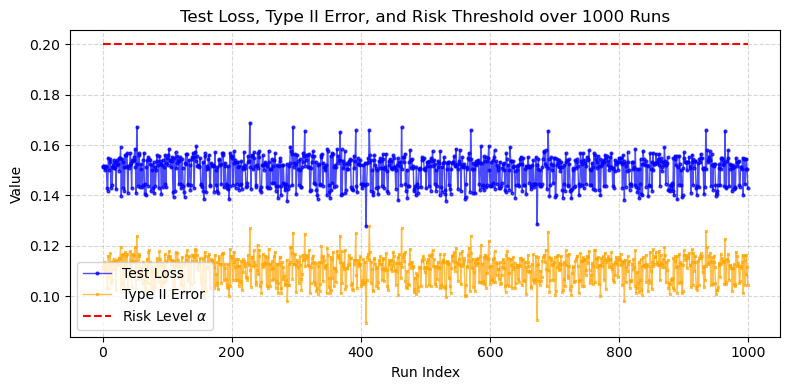

In [39]:
losses = np.array(all_test_losses)
errors = np.array(all_test_errors)
alphas = np.full_like(losses, args.alpha)

# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Test Loss', color='blue', alpha=0.7, marker='o', markersize=2, linewidth=1)
plt.plot(errors, label='Type II Error', color='orange', alpha=0.7, marker='x', markersize=2, linewidth=1)
plt.plot(alphas, label=r'Risk Level $\alpha$', color='red', linestyle='--')

plt.title("Test Loss, Type II Error, and Risk Threshold over 1000 Runs")
plt.xlabel("Run Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()